In [ ]:
import os
import numpy as np
import pandas as pd

results_dir = ".../Transformer_CH_Finetuned_Results"

metric_files = sorted([f for f in os.listdir(results_dir) if f.startswith("metrics_") and f.endswith(".npy")])

for file_name in metric_files:
    file_path = os.path.join(results_dir, file_name)
    
    try:
        metrics_dict = np.load(file_path, allow_pickle=True).item()
        metrics_df = pd.DataFrame(metrics_dict).T
        
        print(f"\n===== Metrics from: {file_name} =====")
        print(metrics_df.to_string())
        
    except Exception as e:
        print(f"Error reading {file_name}: {e}")

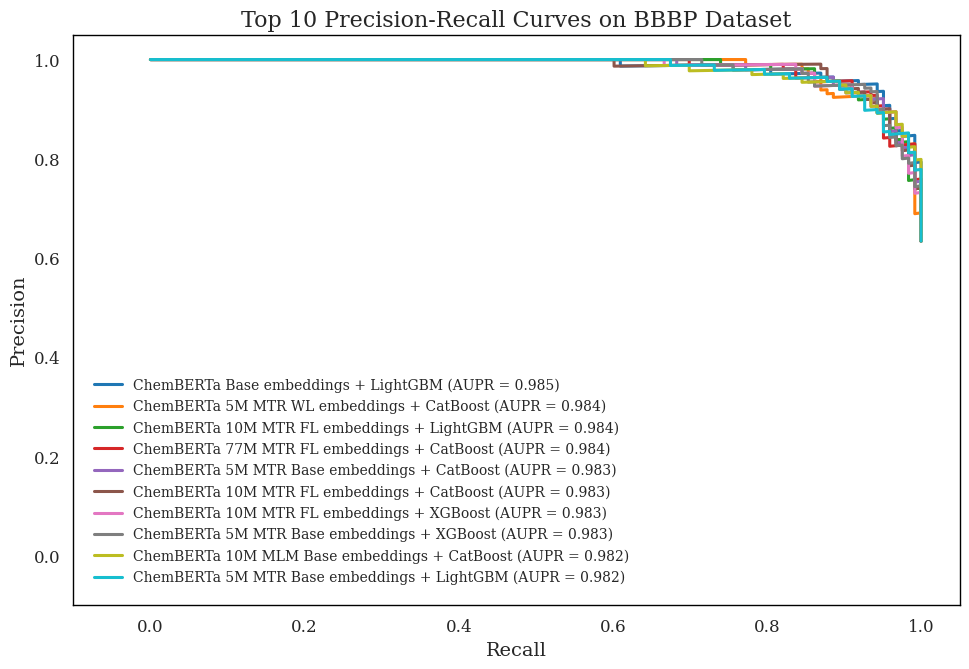

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc

results_dir = ".../Transformer_CH_Finetuned_Results"

# Custom color palette (high contrast for publication)
custom_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
]

# Style setup
sns.set(style="white", font_scale=1.4)
plt.rcParams.update({
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 11,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.0,
})

# Load and process all probability files
files = [f for f in os.listdir(results_dir) if f.startswith("probabilities_") and f.endswith(".npy")]
all_curves = []

for file in files:
    path = os.path.join(results_dir, file)
    try:
        data = np.load(path, allow_pickle=True).item()
        y_true = data.get("y_true")
        if y_true is None or len(np.unique(y_true)) < 2:
            continue

        # Clean label: remove CT_TOX and underscores
        base_name = file.replace("probabilities_", "").replace("p_np", "").replace(".npy", "").replace("_", " ").strip()

        for clf_key in ['XGBoost_proba', 'LightGBM_proba', 'CatBoost_proba']:
            if clf_key not in data:
                continue

            proba = np.array(data[clf_key])
            if proba.ndim != 2 or proba.shape[1] != 2:
                continue

            y_score = proba[:, 1]
            precision, recall, _ = precision_recall_curve(y_true, y_score)
            pr_auc = auc(recall, precision)

            model_label = clf_key.replace("_proba", "")
            curve_name = f"{base_name} + {model_label}"

            all_curves.append({
                'name': curve_name,
                'precision': precision,
                'recall': recall,
                'pr_auc': pr_auc
            })

    except Exception as e:
        print(f"Error loading {file}: {e}")

# Sort and select top 10 by PR AUC
top_10 = sorted(all_curves, key=lambda x: x['pr_auc'], reverse=True)[:10]

# Plotting
plt.figure(figsize=(10, 7))

for i, model in enumerate(top_10):
    plt.plot(model['recall'], model['precision'],
             label=f"{model['name']} (AUPR = {model['pr_auc']:.3f})",
             linewidth=2.2,
             color=custom_colors[i % len(custom_colors)])

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Top 10 Precision-Recall Curves on BBBP Dataset")
plt.xlim([-0.1, 1.05])
plt.ylim([-0.1, 1.05])
plt.grid(False)

# Legend inside plot, sorted by AUPR
handles, labels = plt.gca().get_legend_handles_labels()
sorted_handles = [h for _, h in sorted(zip([m['pr_auc'] for m in top_10], handles), reverse=True)]
sorted_labels = [l for _, l in sorted(zip([m['pr_auc'] for m in top_10], labels), reverse=True)]

plt.legend(sorted_handles, sorted_labels,
           loc='lower left',
           frameon=False,
           borderpad=1.0, fontsize=10)

plt.tight_layout()
plt.savefig("Top10_PR_Curves_BBBP.png", dpi=300, bbox_inches='tight')
plt.show()


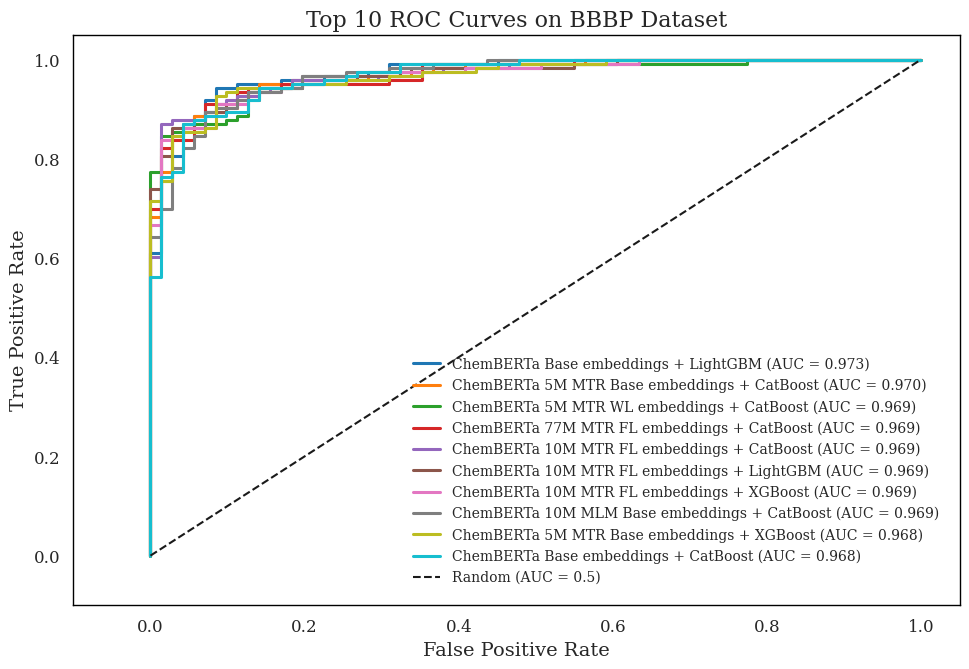

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Set directory
results_dir = ".../Transformer_CH_Finetuned_Results"

# Custom color palette for publication
custom_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
]

# Style setup
sns.set(style="white", font_scale=1.4)
plt.rcParams.update({
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 11,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.0,
})

# Load files
files = [f for f in os.listdir(results_dir) if f.startswith("probabilities_") and f.endswith(".npy")]
all_curves = []

for file in files:
    path = os.path.join(results_dir, file)
    try:
        data = np.load(path, allow_pickle=True).item()
        y_true = data.get("y_true")
        if y_true is None or len(np.unique(y_true)) < 2:
            continue

        base_name = file.replace("probabilities_", "").replace("p_np", "").replace(".npy", "").replace("_", " ").strip()

        for clf_key in ['XGBoost_proba', 'LightGBM_proba', 'CatBoost_proba']:
            if clf_key not in data:
                continue

            proba = np.array(data[clf_key])
            if proba.ndim != 2 or proba.shape[1] != 2:
                continue

            y_score = proba[:, 1]
            fpr, tpr, _ = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)

            model_label = clf_key.replace("_proba", "")
            curve_name = f"{base_name} + {model_label}"

            all_curves.append({
                'name': curve_name,
                'fpr': fpr,
                'tpr': tpr,
                'roc_auc': roc_auc
            })

    except Exception as e:
        print(f"Error loading {file}: {e}")

# Sort and select top 10 by ROC AUC
top_10 = sorted(all_curves, key=lambda x: x['roc_auc'], reverse=True)[:10]

# Plotting
plt.figure(figsize=(10, 7))
plot_handles = []

for i, model in enumerate(top_10):
    handle, = plt.plot(model['fpr'], model['tpr'],
                       label=f"{model['name']} (AUC = {model['roc_auc']:.3f})",
                       linewidth=2.2,
                       color=custom_colors[i % len(custom_colors)])
    plot_handles.append((model['roc_auc'], handle, f"{model['name']} (AUC = {model['roc_auc']:.3f})"))

# Random baseline
random_handle, = plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label="Random (AUC = 0.5)")

# Sort legend entries
plot_handles.sort(reverse=True, key=lambda x: x[0])
sorted_handles = [ph[1] for ph in plot_handles] + [random_handle]
sorted_labels = [ph[2] for ph in plot_handles] + ["Random (AUC = 0.5)"]

# Axis labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Top 10 ROC Curves on BBBP Dataset")
plt.xlim([-0.1, 1.05])
plt.ylim([-0.1, 1.05])
plt.grid(False)

# Legend inside plot (bottom right)
plt.legend(sorted_handles, sorted_labels,
           loc='lower right', frameon=False, borderpad=1.0, fontsize=10)

# Save and show
plt.tight_layout()
plt.savefig("Top10_ROC_Curves_BBBP.png", dpi=300, bbox_inches='tight')
plt.show()
